# Read Me

The one debate that has taken over my thoughts over the past year, continously changing my stance, is that of the Efficient Market Hypothesis, or random walk. Questions like "if the market is in fact governed by our rational and irrational impulses, and presents inefficiencies, then how come hedge funds and investors have a 50% success rate, the same as a coin flip telling us when to buy or sell? Is it true that "blind-folded monkey throwing darts" would do as well a Wall Street analyst?" are contrasted by opposing questions like "if small illiquid markets are proven to be consistintly beat, how is it possible that no inefficiency that can be exploited are found in larger markets?". It seems as the market has to be vulnerable to arbitrage, insider trading and event-driven HFT (unless we assume strong efficient markets), but no one is able to get edge over the market. 

The following notebook is a few paths taken in the direction to find any set of rules, discovered or not, that govern how markets move. Above all, though, it's a where I, and one perhaps, anyone reading this can just experiment with new technologies and strategies.

***

# Predicting with Market Sentiment (V 1.0)
 With the rise of computing power and of publically available data, a hot-topic today is "Sentiment". One of the most basic trading strategies is that of analysing how a group of people (ie the world) feel about a certain topic (ie a company) to predict how the market will move. It makes sense, exchange markets, as the name itself entails, are governed by supply and demand, stocks' prices are determined by what investors as a whole feel the price should be. When investing we are not betting on the future intrinsic value of the stock (if such exists), but on what others think it will be worth.
 Therefore, the most obvious way to predict how people will feel in the future is analysing how they feel now. That is Sentiment Analysis. Unfortunately, I am not the only one to have thought this way, in fact, the following graph shows the search frequency of the query "Sentiment analysis", according to Google.
<img src="sentimentSearchHistory.png"/>

### Analysis Twitter Volume
To start off we will create a model that can search real time for keywords or hashtags on Twitter to predict predefined stock prices. We will plot the frequency (tweets per minute) of a keyword next to the graph of a predifined stock index.

#### 1. Import necessary libaries
Tweepy is Twitter's API that allows us to convieniently search their database of tweets according to author, keywords, popularity and other handy features.

In [1]:
import tweepy
import matplotlib.pyplot as plt
import json
import requests

#### 2. Do necessary authentications
The following is what allows us to access the twitter API.
TODO: Hide secret keys

In [2]:
consumer_key= 'gXtUH5IaLialLO71v1QZhs7rF'
consumer_secret= 'A4tHrkqZ6D96dCGwNLOuRBd0juO8qOpaaP89oUmoPrZNxcWNBj' # Secret
access_token='1027935030360850432-RLhwU4GVbCtrE3cu2PyxfTFBIoVOx1'
access_token_secret='wK62J222AcJso04D6Vpuge5kQbzlW4NJofGM1ncuHFtri' # Secret

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

#### 3. Search the tweets
Now we search for the tweets we want to retrieve. In this demo we will use the keyword "Elon Musk" to predict Tesla's Stock price (TSLA).
Twitter limits the amount of tweets we can receive 'per search' to 100. We must therefore concatenate multiple search to get a statistically significant amount of data. Tweepy, though, also limits the number of requests you can do every 15 minutes (<180). 
Another problem is tweepy doesn't make all tweets available but only the ones of the last 6-9 days.

We are gonna store the tweets we fetched in `tweets_to_analyse`

**This takes a few minutes...**

In [3]:
searchQuery = "LIKE 'elonmusk'" # Keyword
tweets_to_analyse = [] # All the tweets 

number_of_requests = 30
max_id = float('inf') # This is because the first time we search we dont want any max ID

for i in range(number_of_requests):
    tweets = api.search(q=searchQuery, count=100, #tweets for this search
                        result_type = "recent",
                        max_id = max_id,
                        lang = "en")
    tweets_to_analyse.extend(tweets)
    
    if(len(tweets) < 100): #if no more tweets are available
        break
        
    max_id = tweets[99].id #get the id of the last item

print("We have retrieved %s tweets" % len(tweets_to_analyse))

We have retrieved 3000 tweets


In [4]:
query = 'Elon Musk'
max_tweets = 1000
tweets_to_analyse = [status for status in tweepy.Cursor(api.search, q=query).items(max_tweets)]

#### 4. Plotting Volume of tweets
We now want to visualise this data. The idea is that if I have 100 tweets, I get the first and last's timestamps and set my x-axis (time) to have those as extremes. After that i get the tweets that are multiples of 10 and measure the frequency of tweets 

In [5]:
from datetime import datetime

number_of_buckets = 10 #This determines how precise we want our graph to be (how many points to have)

#get the time delta between our first and last registered (timedelta object)
most_recent_timestamp = tweets_to_analyse[0].created_at # this is our 0. We count back in minutes from here
oldest_timestamp = tweets_to_analyse[len(tweets_to_analyse)-1].created_at
total_data_time = most_recent_timestamp - oldest_timestamp #this is the datetime.timedelta that rapresents the amount of time we recorded

delta_in_seconds = -total_data_time.total_seconds() / number_of_buckets #this is negative

#generate the x values
x_data = [0] * number_of_buckets
print(total_data_time)
for i in range(number_of_buckets):
    x_data[i] = (delta_in_seconds * (i+1))/60

#initialize array for y values
tweet_volume = [0] * number_of_buckets
#calculate y values
current_bucket_number = 0
for tweet in tweets_to_analyse:
    #print("bucket number:", current_bucket_number)
    #print("is", (tweet.created_at - most_recent_timestamp).total_seconds(), "smaller than", ((current_bucket_number+1) * delta_in_seconds))
    #print((tweet.created_at - most_recent_timestamp).total_seconds() < (current_bucket_number+1) * delta_in_seconds)
    tweet_volume[current_bucket_number] += 1
    if ((tweet.created_at - most_recent_timestamp).total_seconds() < ((current_bucket_number+1) * delta_in_seconds)):
        current_bucket_number += 1

print(tweet_volume)

3:09:21
[96, 68, 55, 73, 44, 60, 53, 70, 56, 71]


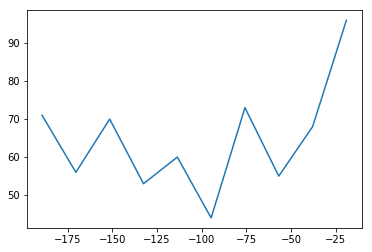

In [6]:
plt.plot(x_data, tweet_volume, label = "tweet volume")

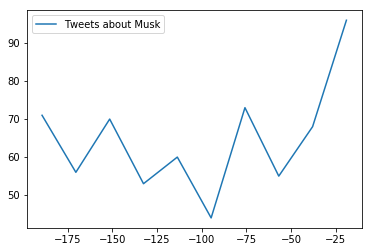

In [13]:
time_in_minutes_elapsed_since_oldest = int((datetime.now() - oldest_timestamp).total_seconds()/60)

###############GET STOCK DATA#################################
#Get data from stock api
response = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=TSLA&interval=5min&apikey=H882E1XRM4DIVG86&outputsize=full") #size to full for full day
json_data = json.loads(response.text)

# set up the minute increment
x_values = [-x for x in list(range(0, int(total_data_time.total_seconds()/60), 5))] # these are timestamps that count back from the present to the oldest tweet in increments of 1 minute
prices = []

counter = 0
for data in json_data['Time Series (5min)']:
    if (counter > int(total_data_time.total_seconds()/60/5)): #Only get the last x minutes worth of data
        break
    data = float((json_data['Time Series (5min)'][data]["1. open"]))
    prices.append(data)
    counter += 1
plt.plot(x_data, tweet_volume, label = "Tweets about Musk")
plt.legend()

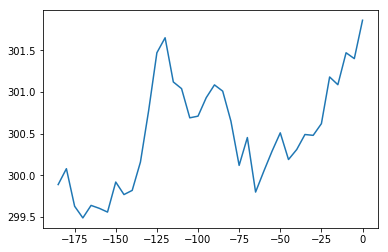

In [14]:
plt.plot(x_values, prices, label = "TSLA price")

### Is there positive correlation between tweet sentiment and stock price?
We are going to use textblob library to perform sentiment analysis on each of the tweets that will score the tweet on a scale from -1 to +1 where -1 is a negative sentiment, 0 and objective statement or a statement without sentiment and +1 a positive statement.

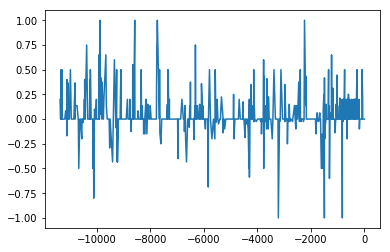

In [15]:
from textblob import TextBlob

x_values = [] # the timestamps of the tweets, counting backwards from present
y_values = [] # the sentiment of the tweets [-1; +1]
for tweet in tweets_to_analyse:
    tweet_date = tweet.created_at
    rel_date = tweet_date - most_recent_timestamp
    x_values.append(rel_date.total_seconds())
    y_values.append(TextBlob(tweet.text).sentiment.polarity)
    
plt.plot(x_values, y_values, label = "Tweet sentiment")

***

## Building a spider to scrape off other media outlets

## Conclusion and possible improvements
While from a technical standpoint this was an interesting approach, for a financial point of view no ground breaking discoveries were made. While I was expecting to find correlation between tweet volume and/or sentiment compared to stock prices, I was expecting to be unexploitable as I thought much more advanced sentiment analysis tools and faster computers would be able to buy and sell accordingly, in less than a few a milliseconds. I seem to have found no noticeable correlation, one option would to be to apply **linear regression** or more complicated *machine learning* models in order find patterns.
It would also be easier to analyse historical data rather than real time data, maybe analysing some big events that lead to sores or plummits of a stock, just to see if even there any patterns can be noticed; and once having developed a model, then testing it in a larger unrpredictable "common-day" market.